# Imports

In [4]:
import os # for changing cwd
import numpy as np
import h5py # lets you store huge amounts of numerical data, and easily manipulate that data from NumPy
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import accuracy_score
from sys import getsizeof 

In [5]:
print(tf.__version__)

2.8.2


# Helper Functions

In [6]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [7]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

## Import the Fashion MNIST dataset

[Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>


In [8]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [9]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Explore the data

In [10]:
train_images.shape

(60000, 28, 28)

In [11]:
len(train_labels)

60000

In [12]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

# Test Dataset

In [13]:
test_images.shape

(10000, 28, 28)

In [14]:
len(test_labels)

10000

## Preprocessing

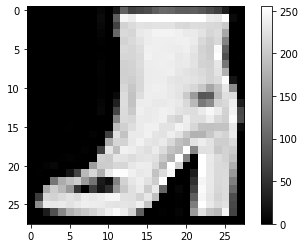

In [15]:
plt.figure()
plt.imshow(train_images[88], cmap="gray")
plt.colorbar()
plt.grid(False)
plt.show()

In [16]:
train_images = train_images / 255.0
test_images = test_images / 255.0

## Build & Compile the model


In [17]:
model = keras.Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10)
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='adam',
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 7s 2ms/step - loss: 0.4986 - accuracy: 0.8245
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3727 - accuracy: 0.8652
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3355 - accuracy: 0.8785
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3132 - accuracy: 0.8849
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2951 - accuracy: 0.8902
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2816 - accuracy: 0.8956
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2676 - accuracy: 0.9007
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2572 - accuracy: 0.9041
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2475 - accuracy: 0.9076
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.240

In [21]:
KERAS_MODEL_NAME = "tf_model_fashion_mnist.h5"

In [22]:
model.save(KERAS_MODEL_NAME)

In [23]:
convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")

File size: 1.191 Megabytes


In [24]:
keras_model_size = get_file_size(KERAS_MODEL_NAME)

In [25]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy is {}%'.format(round(100*test_acc, 2)))

313/313 - 1s - loss: 0.3223 - accuracy: 0.8840 - 675ms/epoch - 2ms/step

Test accuracy is 88.4%


# TF Lite Size Quantized

In [26]:
TF_LITE_SIZE_QUANT_MODEL_FILE_NAME = "tf_lite_quant_model.tflite"

In [27]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = tf_lite_converter.convert()

In [28]:
tflite_model_name = TF_LITE_SIZE_QUANT_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

103936

In [29]:
convert_bytes(get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME), "KB")

File size: 101.5 Kilobytes


In [30]:
tflite_float_quant_file_size = get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)

In [31]:
tflite_float_quant_file_size/keras_model_size

0.0832478982981341

# Accuracy of the Quantized Model

# Check Input Tensor Shape

In [32]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 28 28]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 10]
Output Type: <class 'numpy.float32'>


# Resize Tensor Shape

In [33]:
interpreter.resize_tensor_input(input_details[0]['index'], (10000, 28, 28))
interpreter.resize_tensor_input(output_details[0]['index'], (10000, 10))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [10000    28    28]
Input Type: <class 'numpy.float32'>
Output Shape: [10000    10]
Output Type: <class 'numpy.float32'>


In [34]:
test_images.dtype

dtype('float64')

In [35]:
test_imgs_numpy = np.array(test_images, dtype=np.float32)

In [36]:
interpreter.set_tensor(input_details[0]['index'], test_imgs_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (10000, 10)


In [37]:
acc = accuracy_score(prediction_classes, test_labels)

In [38]:
print('Test accuracy TFLITE Quantized model is {}%'.format(round(100*acc, 2)))

Test accuracy TFLITE Quantized model is 88.43%
